# Simple notebook to read the files and understand the data

In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

### Read the data from both files

In [2]:
# specify the path to the two files with Lyman alpha skewers, with (ON) and without (OFF) self-shielding 
fname_on='data/spectra_ASTRID_self-shield_off_z2.5_500x500x2500.hdf5'
fname_off='data/spectra_ASTRID_z2.5_500x500x2500.hdf5'

In [3]:
with h5py.File(fname_off,'r') as f:
    tau_off = f['tau/H/1/1215'][:]
    colden = f['colden']['H/1'][:]
    axes = f['spectra/axes'][:]
    # (x,y,z) start of the skewers, in kpc/h
    cofm_hkpc = f['spectra/cofm'][:]

In [4]:
with h5py.File(fname_on,'r') as f:
    tau_on = f['tau/H/1/1215'][:]
    # column densities were not stored for this file (should be the same as in the other file)
    #colden_on = f['colden']['H/1'][:]
    axes_on = f['spectra/axes'][:]
    cofm_on = f['spectra/cofm'][:]

### Play with the information describing the skewers (positions and axes)

In [5]:
# check that the axes and 2D positions of the skewers are the same in both boxes
if (np.max(axes - axes_on) > 0):
    raise ValueError('axes are not the same in both files')
if (np.max(cofm_hkpc - cofm_on) > 0):
    raise ValueERror('skewers do not have the same position in both files')

In [6]:
# it turns out, all skewers were extracted along the 3rd axis
if np.min(axes) < 3:
    raise ValueError('check the value of the axes in the file')
axis=3

In [7]:
# box lenght in Mpc/h
# this information should be stored in the HDF5, but I couldn't find it... so added it by hand
L_hMpc=250
# number of skewers per side (500)
Nsk=int(np.sqrt(colden.shape[0]))
print(Nsk,'skewers per side')
# number of pixels / cells per skewer (2500)
Np=int(colden.shape[1])
print(Np,'pixels per skewer')
# pixel width (in Mpc/h)
dz_hMpc=L_hMpc/Np
print('pixel width = {:.3f} Mpc/h'.format(dz_hMpc))
# minimum separation between skewers (in Mpc/h)
dxy_hMpc=L_hMpc/Nsk
print('skewer separation = {:.3f} Mpc/h'.format(dxy_hMpc))

500 skewers per side
2500 pixels per skewer
pixel width = 0.100 Mpc/h
skewer separation = 0.500 Mpc/h


In [8]:
# reshape skewer information to have shape (Nsk, Nsk, ?)
#cofm_hMpc = cofm_hkpc.reshape([Nsk,Nsk,3])/1000
#tau_off = tau_off.reshape([Nsk,Nsk,Np])
#tau_on = tau_on.reshape([Nsk,Nsk,Np])
#colden = colden.reshape([Nsk,Nsk,Np])

In [9]:
def skewer_index(ix, iy):
    """Given the ix, iy indices, return the global index of a given skewer"""
    return ix*Nsk+iy

In [10]:
def skewer_ix_iy(isk):
    """Given the global index, return the (ix, iy) indices of a skewer"""
    ix=isk//Nsk
    iy=isk-ix*Nsk    
    return ix, iy

In [11]:
def skewer_xy_hMpc(isk):
    """Return the (x,y) coordinates of a given skewer, in Mpc/h"""
    ix, iy = skewer_ix_iy(isk)
    return dxy_hMpc*ix, dxy_hMpc*iy

In [12]:
skewer_index(2,0)

1000

In [13]:
skewer_ix_iy(1000)

(2, 0)

In [14]:
isk=123456
x_hMpc, y_hMpc=skewer_xy_hMpc(isk)
print('skewer {} starts at position x={}, y={} Mpc/h'.format(isk, x_hMpc, y_hMpc))

skewer 123456 starts at position x=123.0, y=228.0 Mpc/h


### Play with the column density values

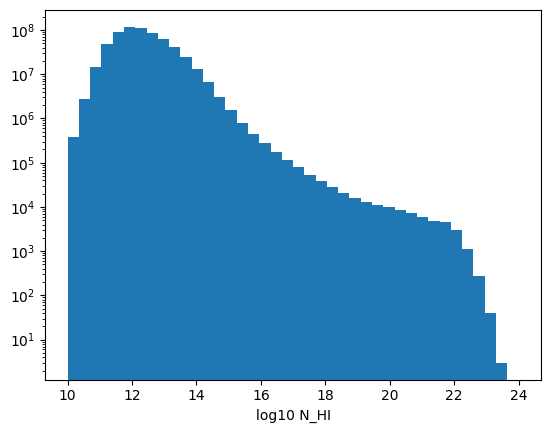

In [15]:
# there really shouldn't be any cell with N_HI=0, we will mask them for now
plt.hist(np.log10(colden[colden>0]),bins=40,range=[10,24],log=True)
plt.xlabel('log10 N_HI');

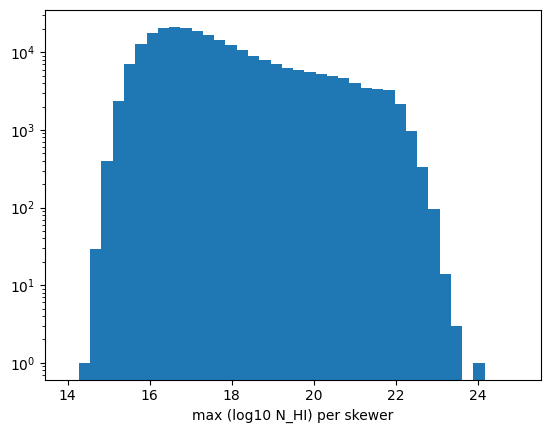

In [16]:
# 2D array with maximum column densities in skewers
max_colden=np.max(colden.reshape([Nsk,Nsk,Np]),axis=2)
plt.hist(np.log10(max_colden).flatten(),bins=40,range=[14,25],log=True)
plt.xlabel('max (log10 N_HI) per skewer');

### Play with the flux skewers 

In [17]:
# find an interesting skewer to plot (20 < log N < 21)
plot_mask = ((max_colden > 1e20) & (max_colden < 1e21)).flatten()
plot_isk=np.where(plot_mask)[0][100]
print(plot_isk)

1113


In [18]:
# find the maximum colden for that skewer
idla=np.argmax(colden[plot_isk])
print(idla)

1726


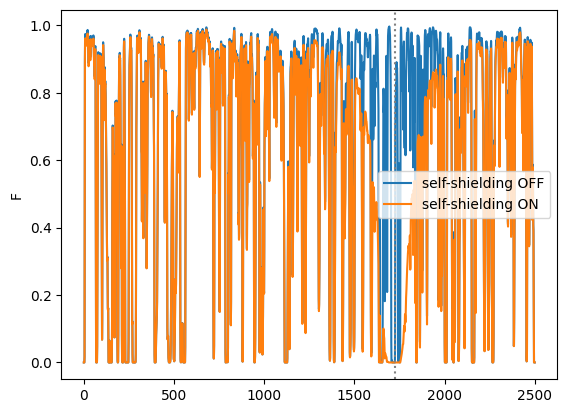

In [19]:
# plot the skewer with and without self-shielding
plt.plot(np.exp(-tau_on[plot_isk]),label='self-shielding OFF')
plt.plot(np.exp(-tau_off[plot_isk]),label='self-shielding ON')
plt.axvline(x=idla,ls=':',color='gray')
plt.ylabel('F')
plt.legend();

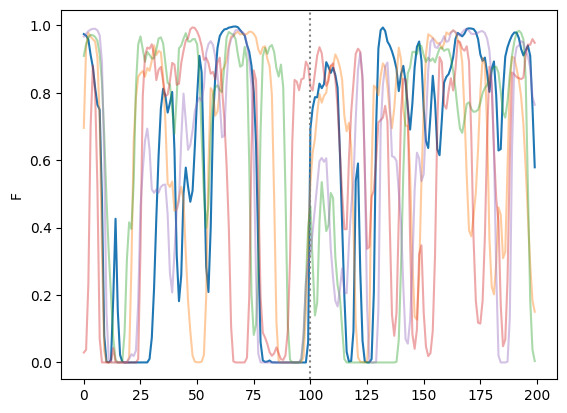

In [20]:
# plot the interesting skewer and its neighbours, around the DLA
dl=100
plot_ix, plot_iy = skewer_ix_iy(plot_isk)
plt.plot(np.exp(-tau_on[plot_isk][idla-dl:idla+dl]),label='DLA')
plot_isk_mm=skewer_index(plot_ix-1,plot_iy-1)
plot_isk_mp=skewer_index(plot_ix-1,plot_iy+1)
plot_isk_pm=skewer_index(plot_ix+1,plot_iy-1)
plot_isk_pp=skewer_index(plot_ix+1,plot_iy+1)
plt.plot(np.exp(-tau_on[plot_isk_mm])[idla-dl:idla+dl],label='(-1, -1)',alpha=0.4)
plt.plot(np.exp(-tau_on[plot_isk_mp])[idla-dl:idla+dl],label='(-1, +1)',alpha=0.4)
plt.plot(np.exp(-tau_on[plot_isk_pm])[idla-dl:idla+dl],label='(+1, -1)',alpha=0.4)
plt.plot(np.exp(-tau_on[plot_isk_pp])[idla-dl:idla+dl],label='(+1, +1)',alpha=0.4)
plt.axvline(x=dl,ls=':',color='gray')
plt.ylabel('F');
#plt.legend();